In [1]:
import pandas as pd
from tomlkit import inline_table
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

def default_plot_settings(sns):
    sns.set()
    sns.mpl.rcParams['figure.figsize'] = (15.0, 7.5)
    sns.mpl.rcParams['axes.labelsize'] = 18
    sns.mpl.rcParams['axes.titlesize'] = 20
    sns.mpl.rcParams['font.size'] = 16
    sns.mpl.rcParams['lines.linewidth'] = 2.0
    sns.mpl.rcParams['lines.markersize'] = 8
    sns.mpl.rcParams['legend.fontsize'] = 14
    sns.set_palette('colorblind')
    return sns


%matplotlib inline
sns = default_plot_settings(sns)


In [2]:
DIR_DATA = '/Users/mohanli/Documents/citadel/46924_Natual_Language_Processing-Applications_in_Finance/proj1/data/'
df_raw = pd.read_csv(
    DIR_DATA + 'filtered_sp500.csv', index_col=0)


In [3]:
df_raw

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,cik,sic,naics,gind,gsubind
0,2011-01-31,60986,NEWELL RUBBERMAID INC,65122910,11,1,3089,NWL,7875,1,1989-04-27,2022-03-31,0.058856,814453.0,3990,3399,252010,25201050
1,2011-01-31,85914,BEST BUY COMPANY INC,8651610,11,1,5731,BBY,2184,1,1999-06-30,2022-03-31,-0.008457,764478.0,5731,443142,255040,25504020
2,2011-01-31,80711,APARTMENT INVESTMENT & MGMT CO,03748R10,18,1,6798,AIV,30490,1,2003-03-14,2020-12-18,-0.010836,922864.0,6798,531110,601010,60101060
3,2011-01-31,59176,AMERICAN EXPRESS CO,2581610,11,1,6141,AXP,1447,1,1976-07-01,2022-03-31,0.014912,4962.0,6141,522210,402020,40202010
9,2011-01-31,59408,BANK OF AMERICA CORP,6050510,11,1,6021,BAC,7647,1,1976-07-01,2022-03-31,0.029235,70858.0,6020,522110,401010,40101010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66113,2021-12-31,83143,IRON MOUNTAIN INC NEW,46284V10,18,1,4226,IRM,62374,1,2009-01-06,2022-03-31,0.165240,1020569.0,6798,531120,601010,60101080
66114,2021-12-31,76605,AUTOZONE INC,5333210,11,1,5531,AZO,23809,1,1997-01-02,2022-03-31,0.153720,866787.0,5531,441310,255040,25504050
66115,2021-12-31,60097,MEDTRONIC PLC,G5960L10,12,1,3845,MDT,7228,1,1986-10-23,2022-03-31,-0.024555,1613103.0,3845,334510,351010,35101010
66116,2021-12-31,27828,H P INC,40434L10,11,1,3571,HPQ,5606,1,1974-10-17,2022-03-31,0.074830,47217.0,3570,33411,452020,45202030


In [4]:
sp500 = pd.read_csv(DIR_DATA + 'sp500.csv', index_col=0)

In [5]:
def calc_access_ret(cik, date, df_raw, sp500):
    len_ = len(df_raw.loc[df_raw['cik'] == cik, 'ticker'].unique())
    if len_ == 1:
        ticker = df_raw.loc[df_raw['cik'] == cik, 'ticker'].iloc[0]
        data = pd.read_pickle(DIR_DATA + f'ret/{ticker}.pkl')
        if len(data[data.index == date]) == 0:
            # print(ticker, 'busted', 'date', date)
            return -1
        close_prev = data.shift(1)[data.index == date]['Close'][0]  # previous day's close
        close_post = data.shift(-3)[data.index == date]['Close'][0]  # 3 days later's close
        ret = (close_post - close_prev) / close_prev
        idx_ = sp500[sp500['caldt'] == date].index[0]
        sp500_ret = sp500[idx_: idx_ + 4]['vwretd'].sum()
        access_ret = ret - sp500_ret
        return access_ret
    else:
        # print(cik)
        # print('matching length', len_)
        return -1


Using proportion

In [26]:
score_prop = pd.read_csv(DIR_DATA + 'score_prop.csv', index_col=0)
access_ret_ls = []
for i in range(len(score_prop)):
    cik, date = score_prop.iloc[i]['cik'], score_prop.iloc[i]['date']
    ret = calc_access_ret(cik, date, df_raw, sp500)
    if ret == -1:
        ret = np.nan
    access_ret_ls.append(ret)
score_prop['access_ret'] = access_ret_ls
score_prop.dropna(inplace=True)
# get rid of bad data points
score_prop = score_prop[(score_prop['access_ret'] > -1) & (score_prop['access_ret'] < 1)]

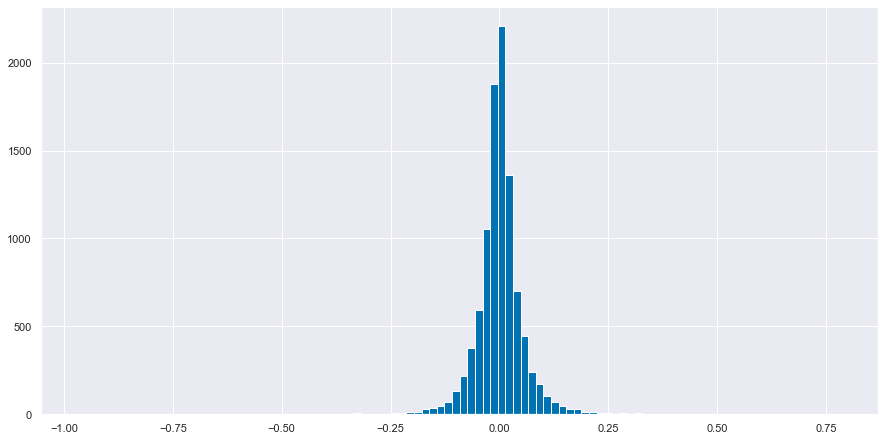

In [27]:
score_prop['access_ret'].hist(bins=100);

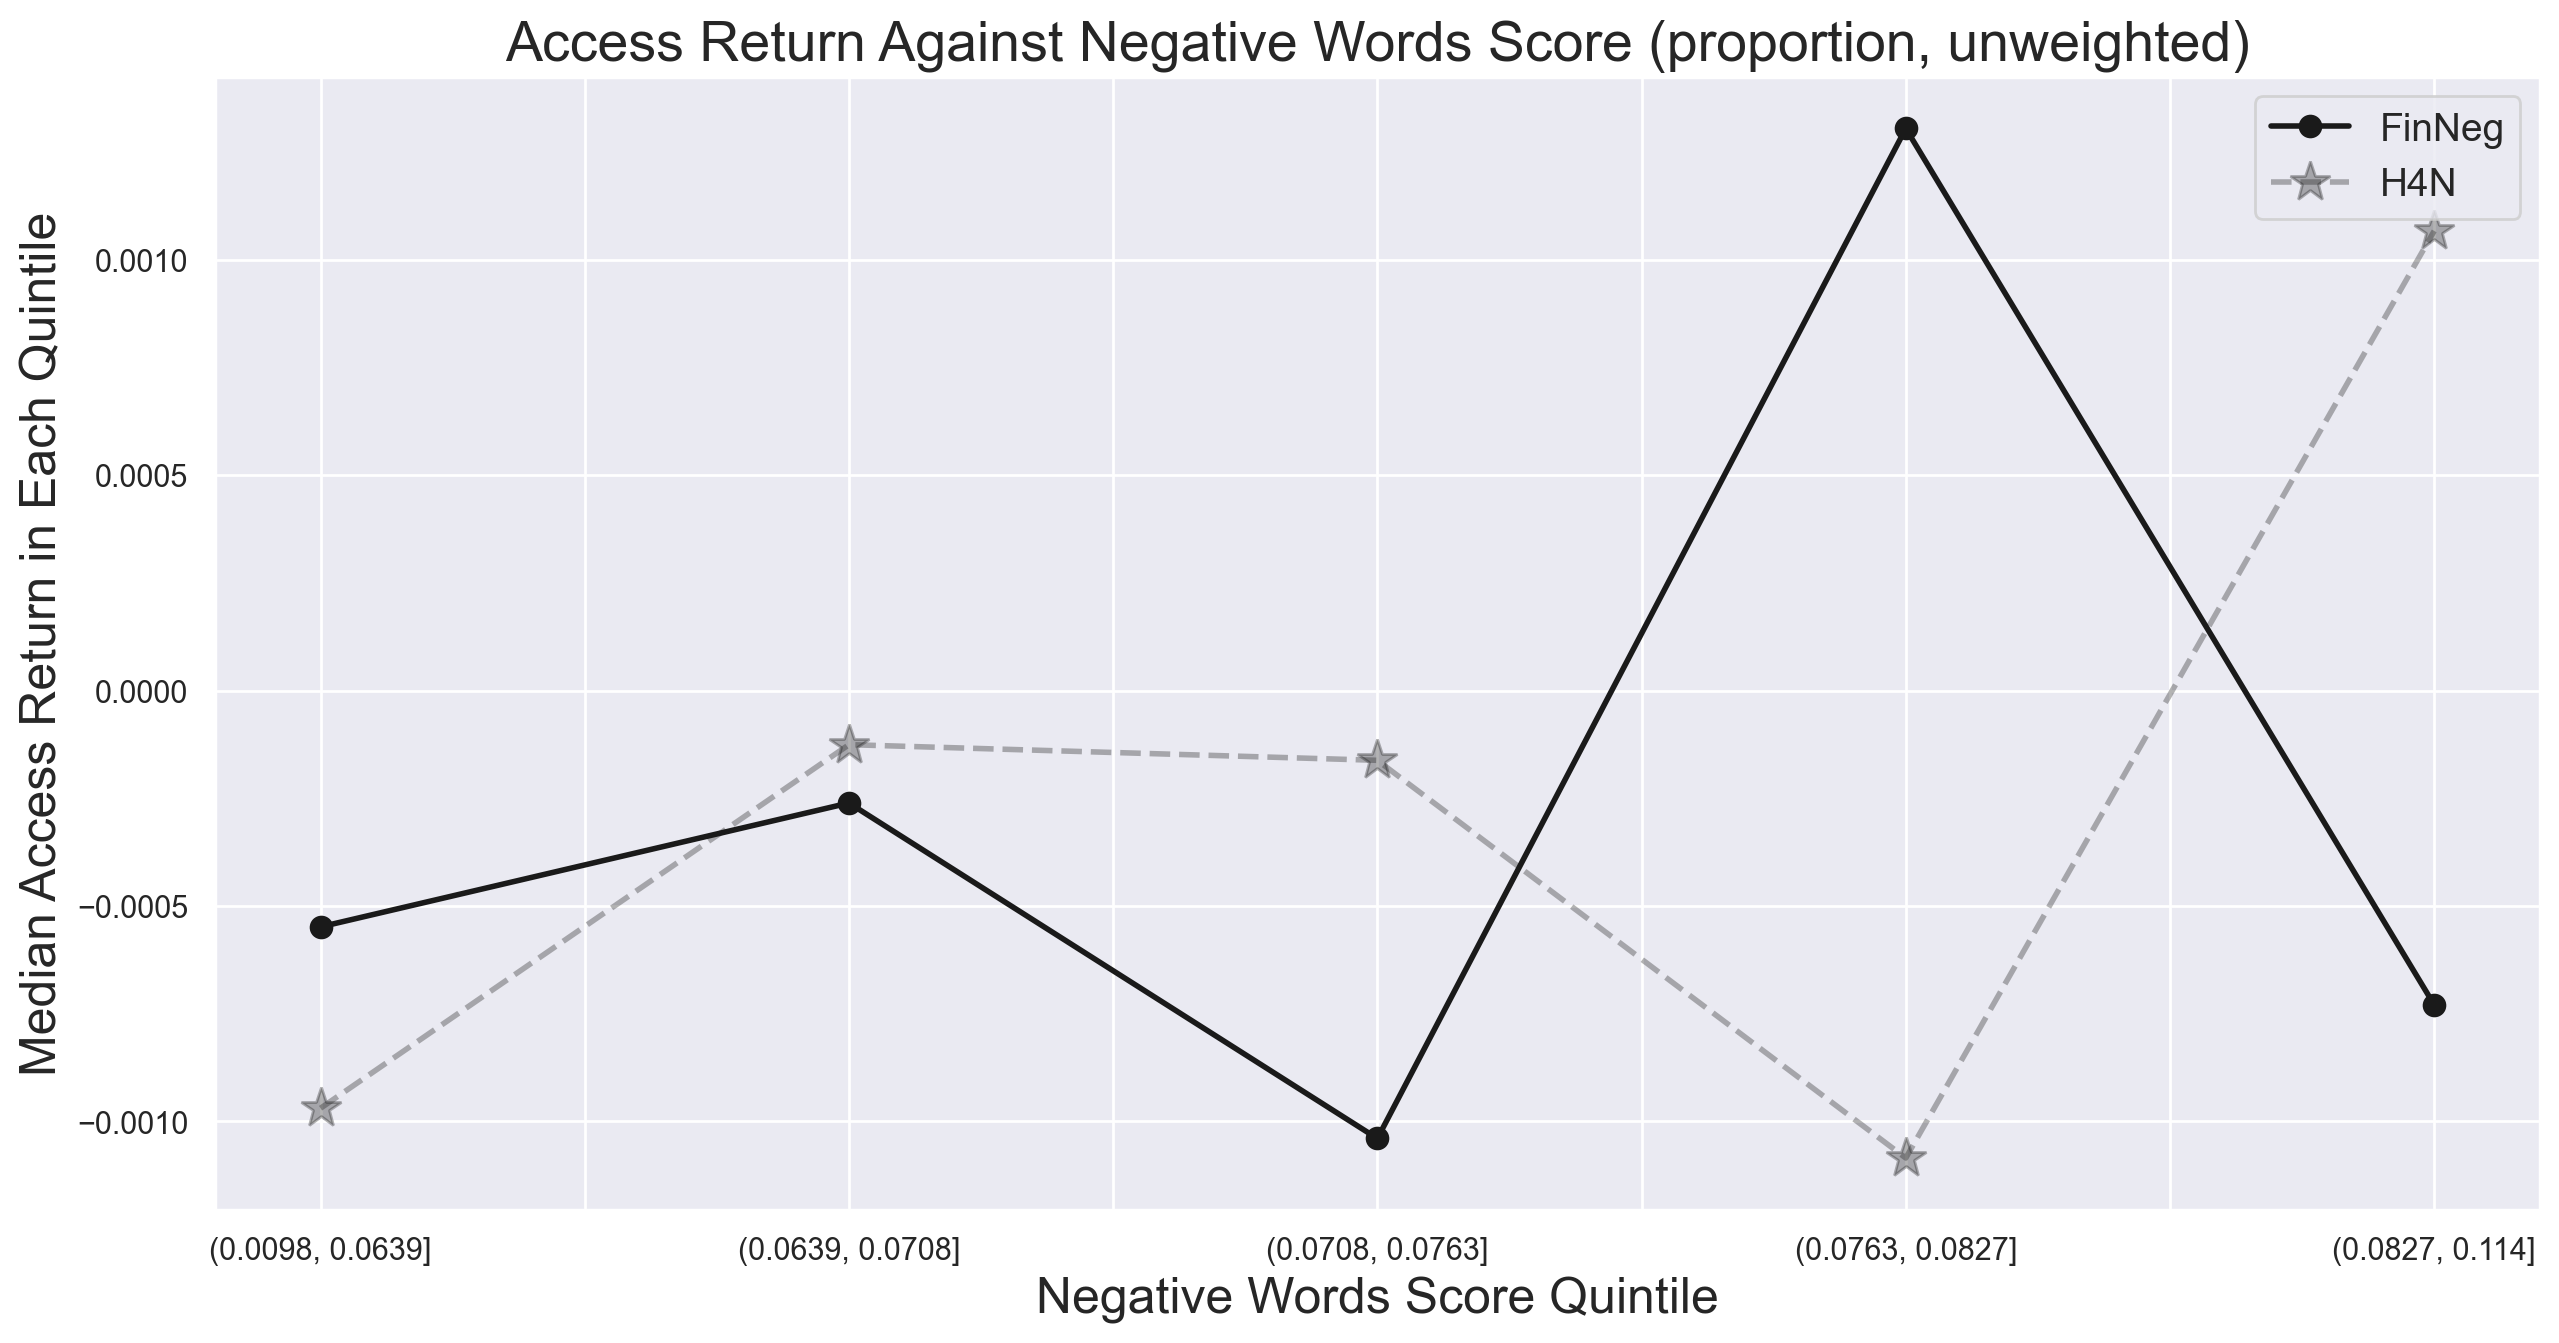

In [28]:
plt.figure(dpi=200)
score_prop.groupby(pd.qcut(score_prop['fin_neg_prop'], q=5))[
    'access_ret'].median().plot(marker=".", markersize=15, c='k', alpha=1.)
score_prop.groupby(pd.qcut(score_prop['h4n_inf_prop'], q=5))[
    'access_ret'].median().plot(marker="*", markersize=15, c='k', alpha=0.33, linestyle='--')
plt.legend(['FinNeg', 'H4N'])
plt.xlabel('Negative Words Score Quintile')
plt.ylabel('Median Access Return in Each Quintile')
plt.title('Access Return Against Negative Words Score (proportion, unweighted)');

Using tfidf

In [29]:
score_tfidf = pd.read_csv(DIR_DATA + 'score_tfidf.csv', index_col=0)
access_ret_ls = []
for i in range(len(score_tfidf)):
    cik, date = score_tfidf.iloc[i]['cik'], score_tfidf.iloc[i]['date']
    ret = calc_access_ret(cik, date, df_raw, sp500)
    if ret == -1:
        ret = np.nan
    access_ret_ls.append(ret)
score_tfidf['access_ret'] = access_ret_ls
score_tfidf.dropna(inplace=True)
score_tfidf = score_tfidf[(score_tfidf['access_ret'] > -1) & (score_tfidf['access_ret'] < 1)]

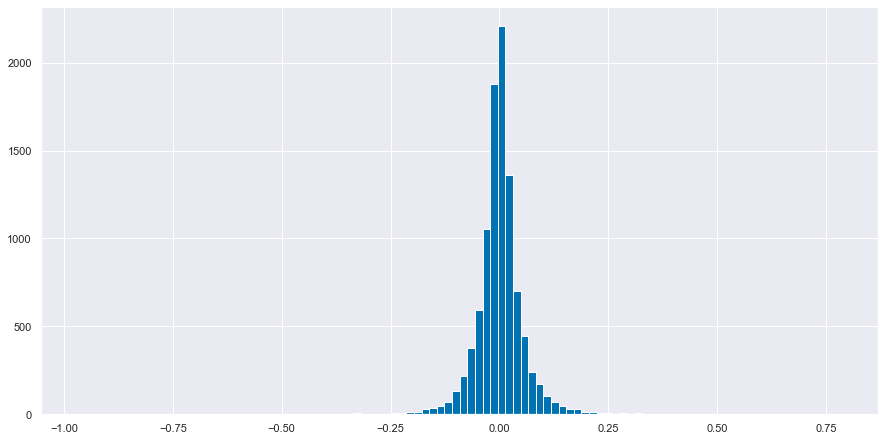

In [30]:
score_tfidf['access_ret'].hist(bins=100);

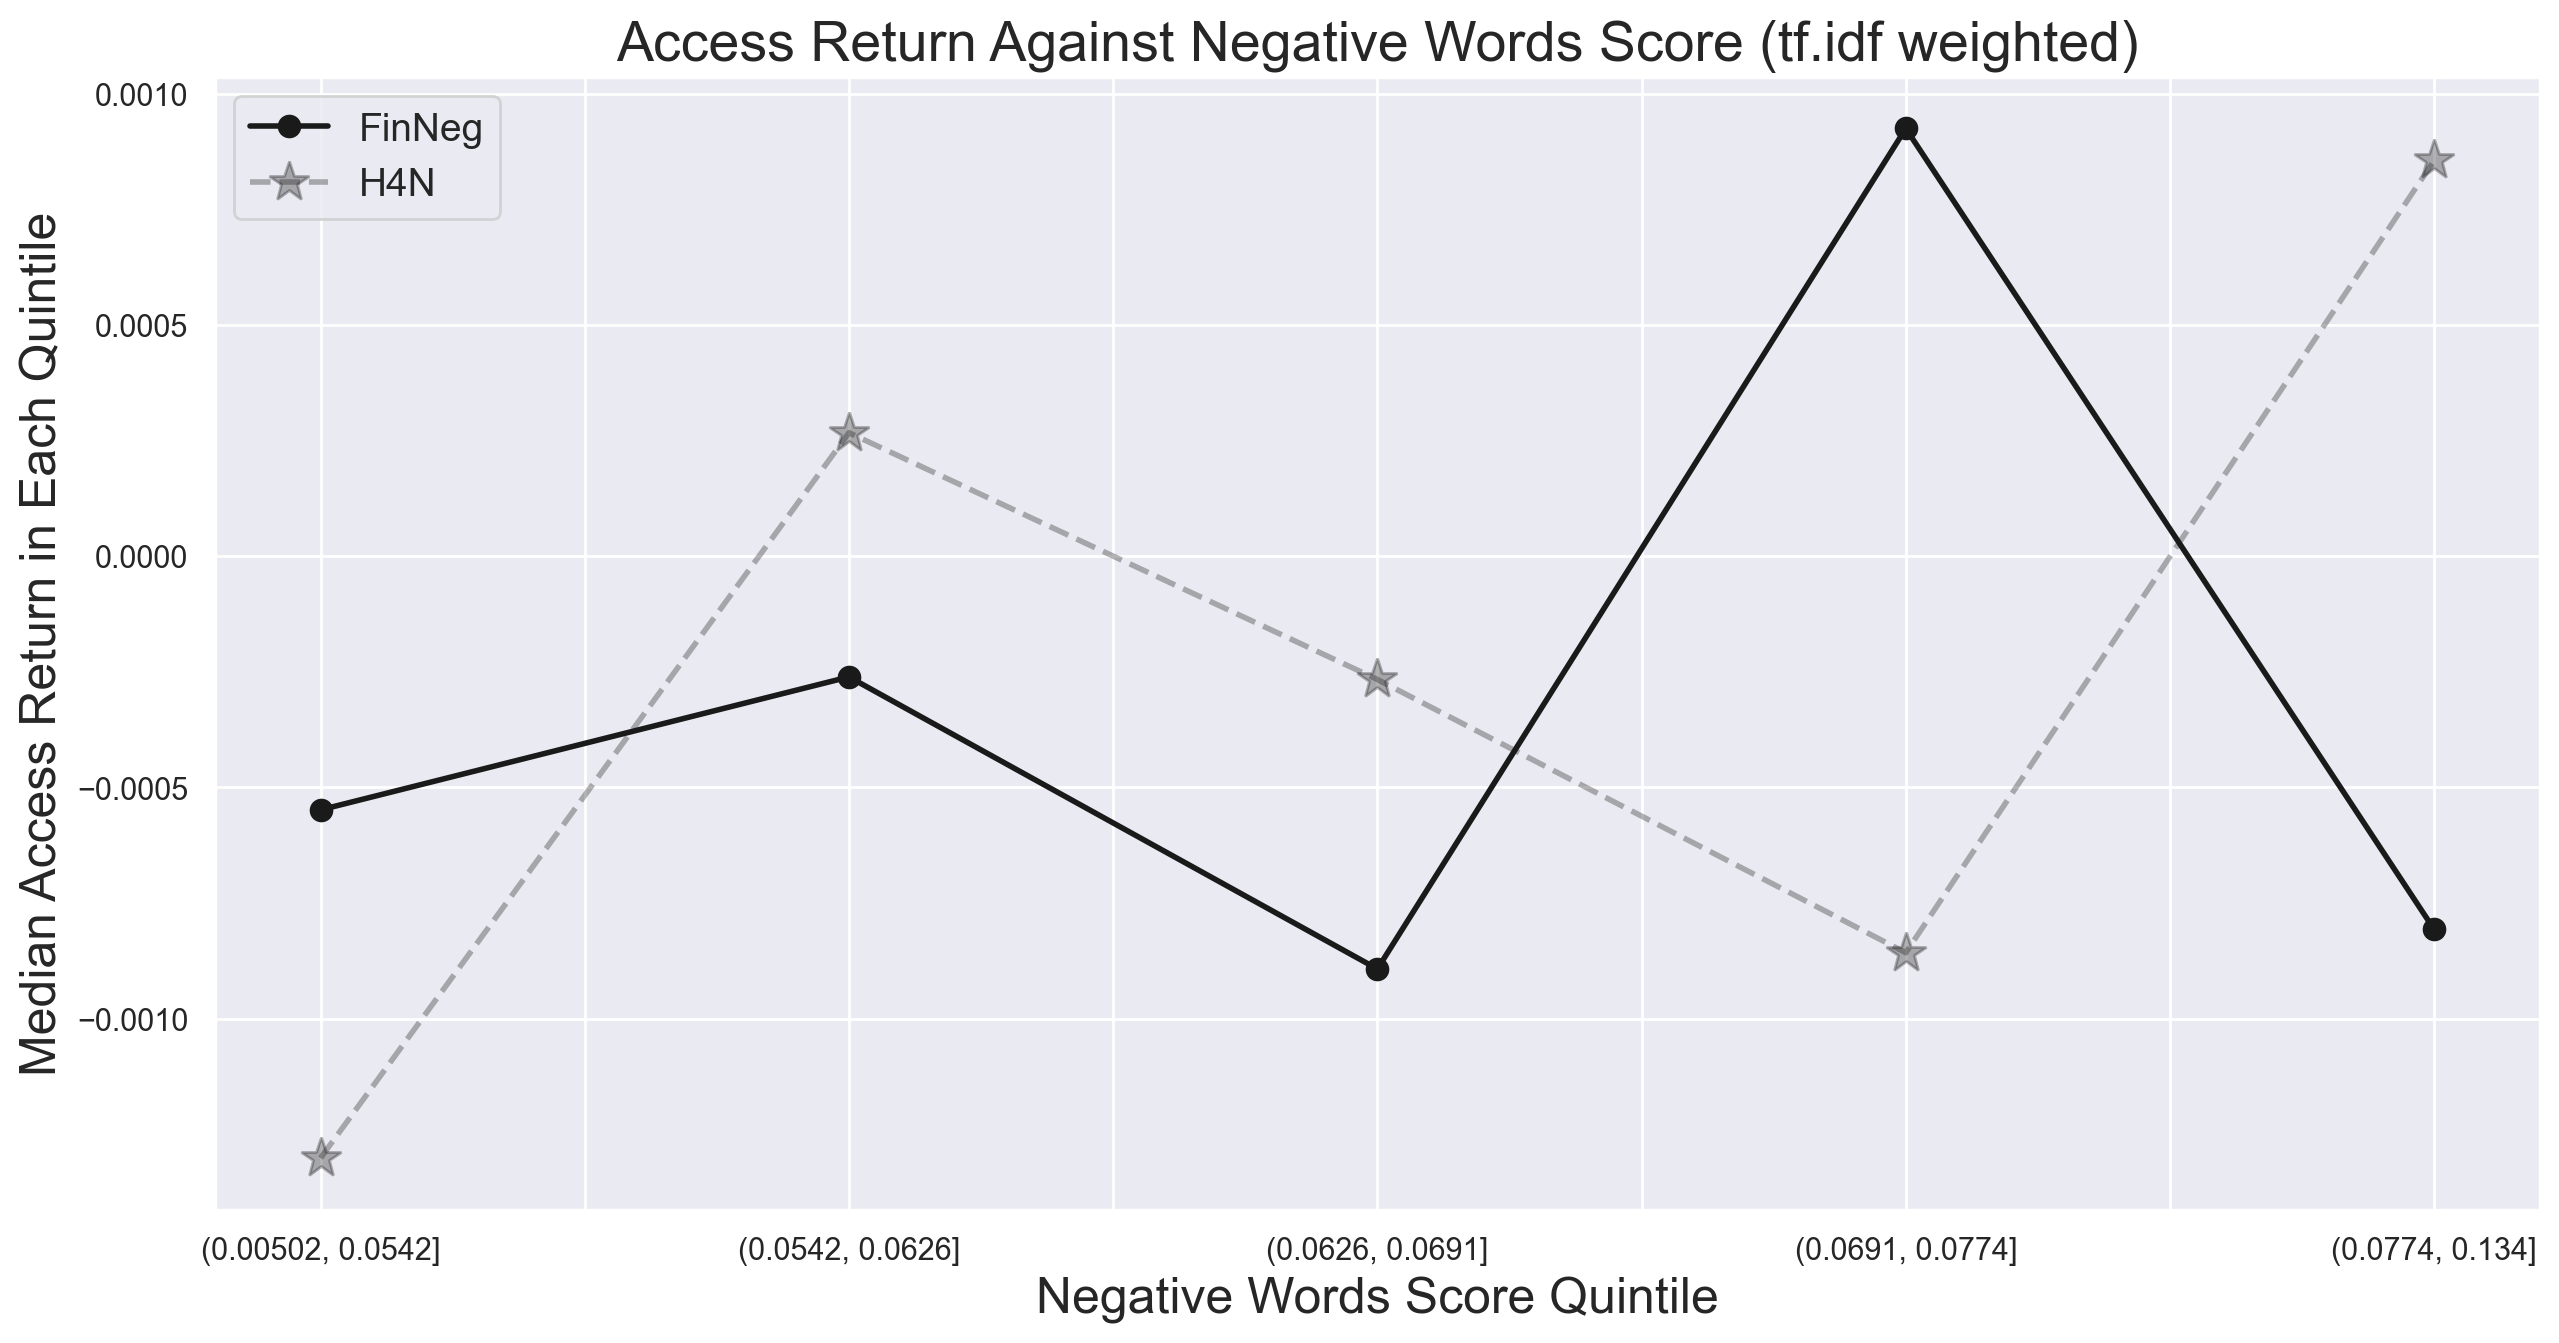

In [31]:
plt.figure(dpi=200)
score_tfidf.groupby(pd.qcut(score_tfidf['fin_neg_scores'], q=5))[
    'access_ret'].median().plot(marker=".", markersize=15, c='k', alpha=1.)
score_tfidf.groupby(pd.qcut(score_tfidf['h4n_inf_scores'], q=5))[
    'access_ret'].median().plot(marker="*", markersize=15, c='k', alpha=0.33, linestyle='--')
plt.legend(['FinNeg', 'H4N'])
plt.xlabel('Negative Words Score Quintile')
plt.ylabel('Median Access Return in Each Quintile')
plt.title('Access Return Against Negative Words Score (tf.idf weighted)');